In [1]:
import warnings
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# don't do this 
warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'

In [2]:
# load walmart ($wmt) historical stock data
wmt = pd.read_csv('data/WMT.csv')

In [3]:
# what's the sitch
wmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11815 entries, 0 to 11814
Data columns (total 7 columns):
Date         11815 non-null object
Open         11815 non-null float64
High         11815 non-null float64
Low          11815 non-null float64
Close        11815 non-null float64
Adj Close    11815 non-null float64
Volume       11815 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 646.2+ KB


In [4]:
# tell me about it
wmt.describe()

,Open,High,Low,Close,Adj Close,Volume
count,11815.000000,11815.000000,11815.000000,11815.000000,11815.000000,1.181500e+04
mean,29.942336,30.226543,29.658511,29.948090,24.052813,7.510762e+06
std,29.802418,30.051176,29.566506,29.811830,26.403796,6.327371e+06
min,0.015625,0.015625,0.014404,0.015625,0.005798,0.000000e+00
25%,1.265625,1.281250,1.253906,1.265625,0.513472,3.753600e+06
50%,13.718750,13.843750,13.562500,13.687500,8.964169,6.263200e+06
75%,54.000000,54.570000,53.500000,54.000000,40.389094,9.515000e+06
max,111.489998,112.220001,111.029999,111.599998,111.599998,1.318336e+08


In [5]:
# let's see
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.023768,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.023678,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.023408,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.023408,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.023047,870400


In [6]:
# forege new dataframe with date and adjusted closing price
wmt = wmt[['Date','Adj Close']]
# adjust column names for prophet compliance
wmt.columns = ['ds','y']
# convert dates from string to datetime
wmt.ds = pd.to_datetime(wmt.ds)

# display adjustments
wmt.tail()

,ds,y
11810,2019-06-26,110.160004
11811,2019-06-27,110.099998
11812,2019-06-28,110.489998
11813,2019-07-01,110.620003
11814,2019-07-02,111.599998


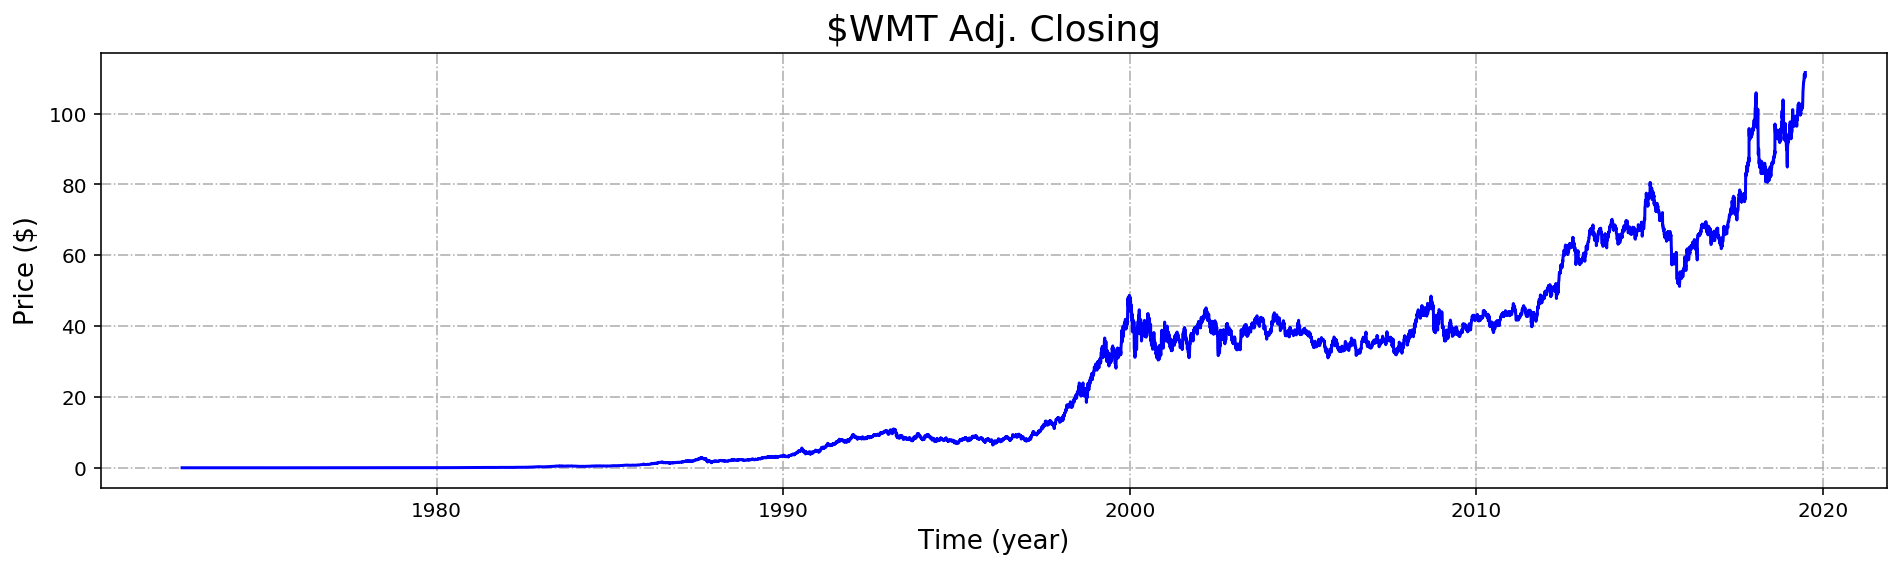

In [7]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(wmt.ds, wmt.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

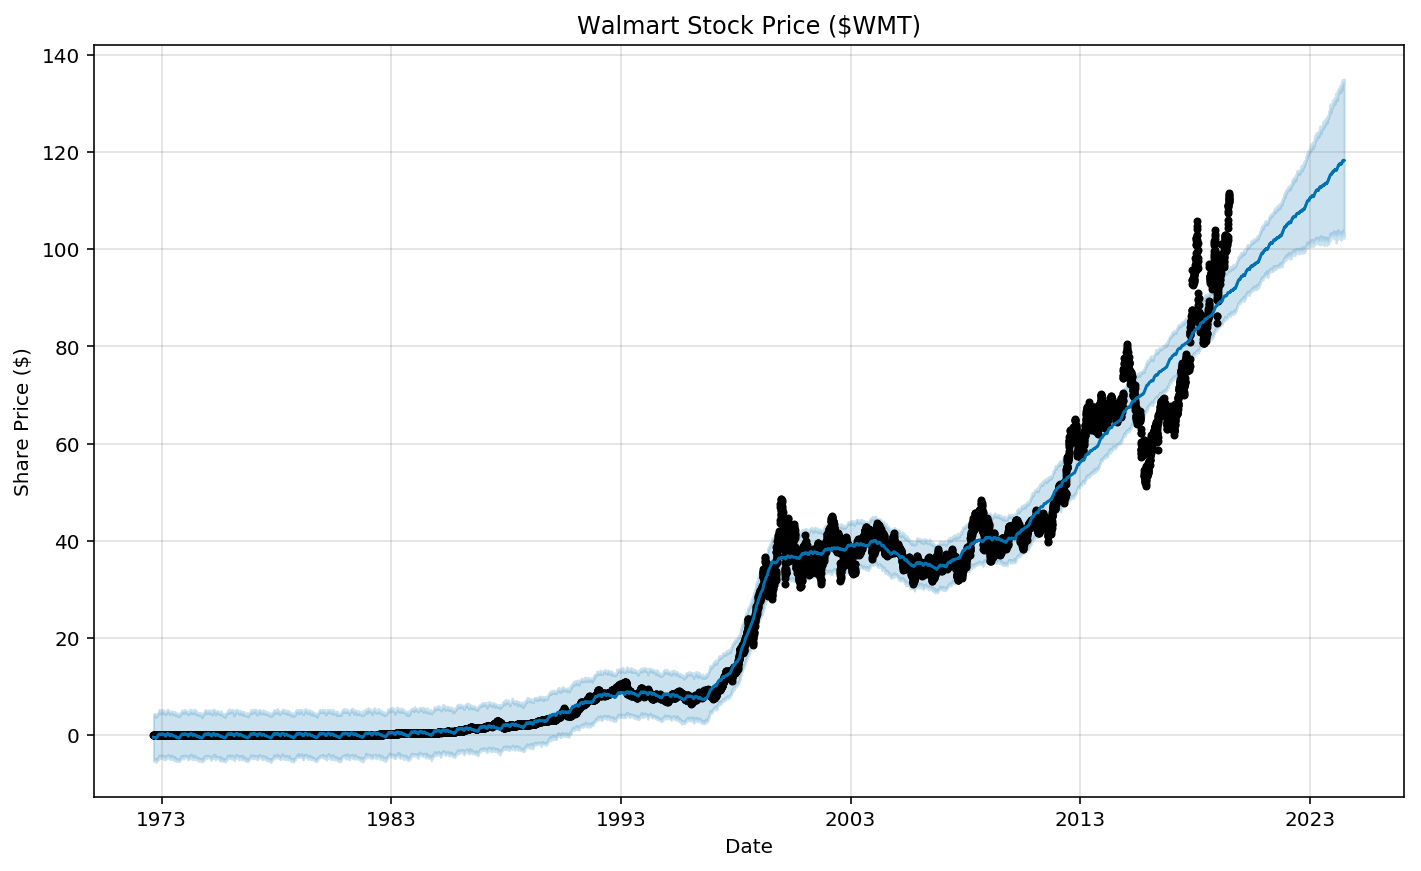

In [8]:
# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False,)
# fit $wmt data to model
prophet.fit(wmt)
# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=365*5, freq='D')
# forecast future df with model
forecast = prophet.predict(build_forecast)

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
plt.show()

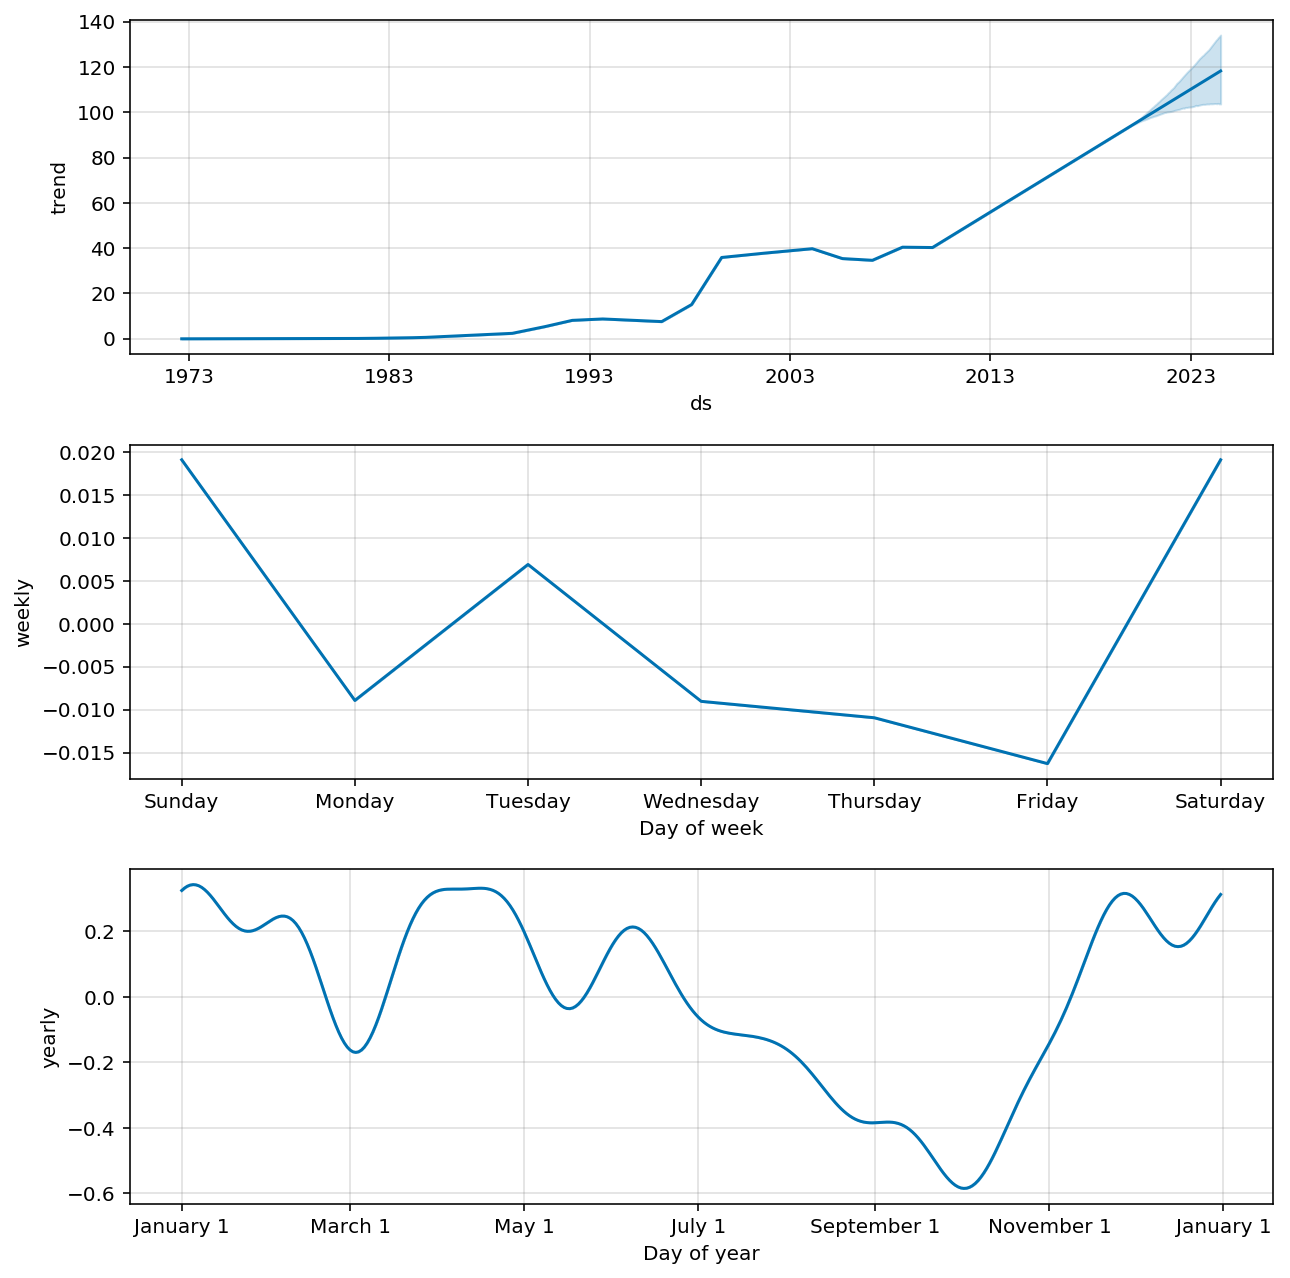

In [9]:
# tell us more about the forecast
components = prophet.plot_components(forecast)

In [10]:
# narrow selection to dates past initial dataframe
future_preds = forecast.loc[forecast.ds>'2019-07-02']
# select date, prediction, lower and upper limits 
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
# display some predictions
future_preds.sample(5)

,ds,yhat,yhat_lower,yhat_upper
13073,2022-12-12,110.041718,101.568184,119.925237
13133,2023-02-10,110.980363,101.712746,121.277479
12253,2020-09-13,97.313107,92.159896,102.221179
12555,2021-07-12,102.065095,96.332726,108.111688
12355,2020-12-24,99.424976,94.531009,105.137846


In [11]:
# cross validate 1 year every half year at 30 years
wmt_cv = cross_validation(prophet, initial='10950 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 33 forecasts with cutoffs between 2002-09-24 00:00:00 and 2018-07-02 00:00:00


In [12]:
# example output 
wmt_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-09-25,46.405346,43.560893,49.271401,37.005474,2002-09-24
1,2002-09-26,46.432691,43.423601,49.603567,38.193005,2002-09-24
2,2002-09-27,46.427095,43.346506,49.448884,36.436600,2002-09-24
3,2002-09-30,46.527837,43.495473,49.634568,35.014393,2002-09-24
4,2002-10-01,46.566061,43.426154,49.470659,36.770809,2002-09-24


In [13]:
# how's the preformance  
wmt_pm = performance_metrics(wmt_cv)

In [14]:
# final accuracy
wmt_pm.tail(3)

,horizon,mse,rmse,mae,mape,coverage
326,363 days,111.806040,10.573838,8.965285,0.168163,0.148193
327,364 days,112.884602,10.624717,8.997063,0.168591,0.147931
328,365 days,114.811519,10.715014,9.072738,0.169538,0.143154


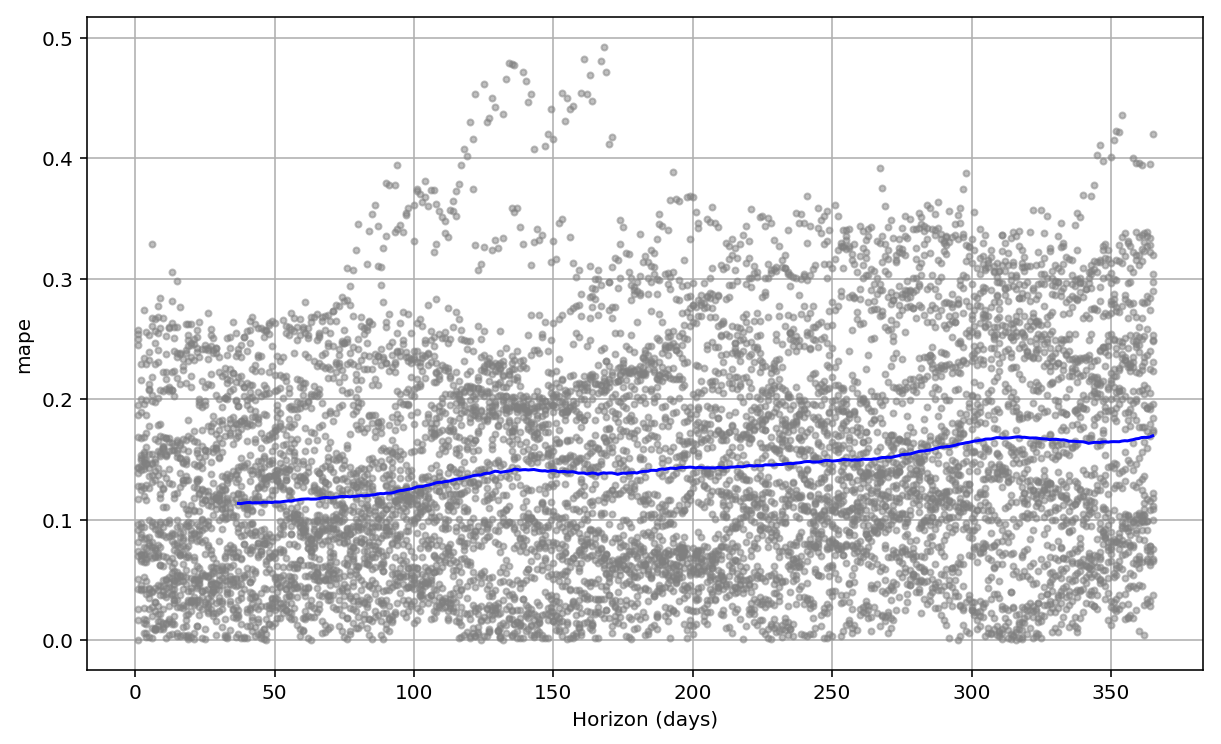

In [15]:
# visualize mape across horizon (continued sort)
fig = plot_cross_validation_metric(wmt_cv, metric='mape')

In [16]:
# where did prophet identify changepoints
prophet.changepoints

378    1974-02-28
756    1975-08-27
1134   1977-02-24
1512   1978-08-24
1890   1980-02-22
2268   1981-08-21
2646   1983-02-17
3024   1984-08-16
3402   1986-02-14
3780   1987-08-14
4158   1989-02-10
4536   1990-08-10
4915   1992-02-10
5293   1993-08-09
5671   1995-02-06
6049   1996-08-05
6427   1998-02-03
6805   1999-08-04
7183   2001-02-01
7561   2002-08-08
7939   2004-02-09
8317   2005-08-09
8695   2007-02-09
9073   2008-08-11
9451   2010-02-10
Name: ds, dtype: datetime64[ns]